# FOREST COVER TYPE CLASSIFICATION

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings ("ignore")
sns.set(style="whitegrid")

In [2]:
#Config
SAMPLE_FRAC = 1.0
RANDOM_STATE = 42     # set 1.0 for suick experiments (e.g., 0.1)
TEST_SIZE = 0.2

#For hypErparameter search (fast defaults). Increase n_iter for better Tuning.
RF_SEARCH_ITERS = 8
XGB_SEARCH_ITERS = 10
CV_FOLDS = 3

### Load dataset

In [3]:
#Load dataset
print("Loading Covertype dataset...")
cov = fetch_covtype()
X = pd.DataFrame(cov.data, columns=cov.feature_names)
y= pd.Series(cov.target, name="cover_type") # values 1..7

print("Original shape:", X.shape)
print("Target distribution:\n", y.value_counts().sort_index())

Loading Covertype dataset...
Original shape: (581012, 54)
Target distribution:
 cover_type
1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
Name: count, dtype: int64


In [4]:
#2) Clean & preprocess

#The dataset has already binary soil/wilderness indicators; no missing values.
print("Missing values total:", X.isna().sum().sum())

#Map labels 1..7 -> 0..6 for convenience with sklearn/xgboost
y_enc = (y - 1).astype(int)

# Stratified split to preserve class proportions
X_train, X_test, y_train, y_test =  train_test_split( 
    X, y_enc, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_enc
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
#Scale numeric features - optional for tree models, but helpful if later using linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Missing values total: 0
Train shape: (464809, 54) Test shape: (116203, 54)


In [5]:
#Utility plotting & reporting

def plot_confusion(y_true, y_pred, labels=None, title="Confusion matrix", figsize=(8,6)):
    cm_abs = confusion_matrix(y_true, y_pred)
    cm_norm = confusion_matrix(y_true, y_pred, normalize='true') # per-class recall
    plt.figure(figsize=figsize)
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(title + " (normalized per true class)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    #also show absolute counts
    plt.figure(figsize=figsize)
    sns.heatmap(cm_abs, annot=True, fmt="d", cmap="OrRd", xticklabels=labels, yticklabels=labels)
    plt.title(title + " (absolute counts)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def show_results(y_true, y_pred, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    print(f"--- {model_name} ---")
    print(f"Accuracy: {acc:.4f}")
    print("Classification report:")
    print(classification_report(y_true, y_pred, digits=4))
    labels = [str(i) for i in range(1, 8)]
    plot_confusion(y_true, y_pred, labels=labels, title=model_name + " Confusion Matrix")


Training Random Forest baseline...
Random Forest trained in 103.3s
--- Random Forest (baseline) ---
Accuracy: 0.9543
Classification report:
              precision    recall  f1-score   support

           0     0.9647    0.9422    0.9533     42368
           1     0.9492    0.9737    0.9613     56661
           2     0.9385    0.9600    0.9491      7151
           3     0.9159    0.8525    0.8830       549
           4     0.9529    0.7778    0.8565      1899
           5     0.9309    0.8917    0.9109      3473
           6     0.9735    0.9481    0.9606      4102

    accuracy                         0.9543    116203
   macro avg     0.9465    0.9066    0.9250    116203
weighted avg     0.9544    0.9543    0.9540    116203



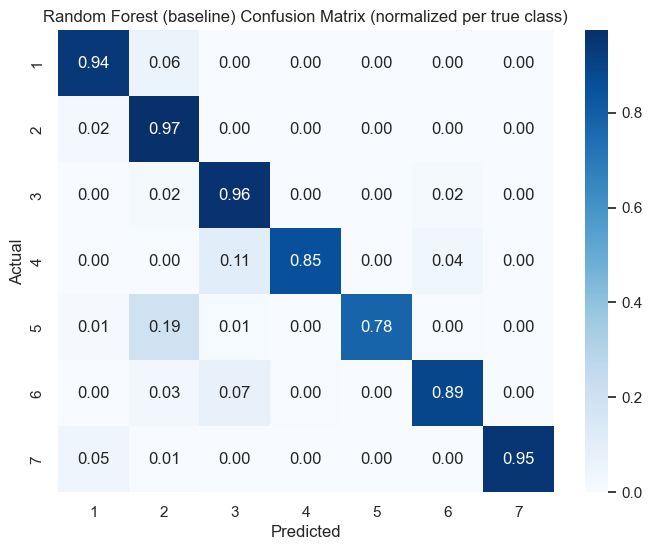

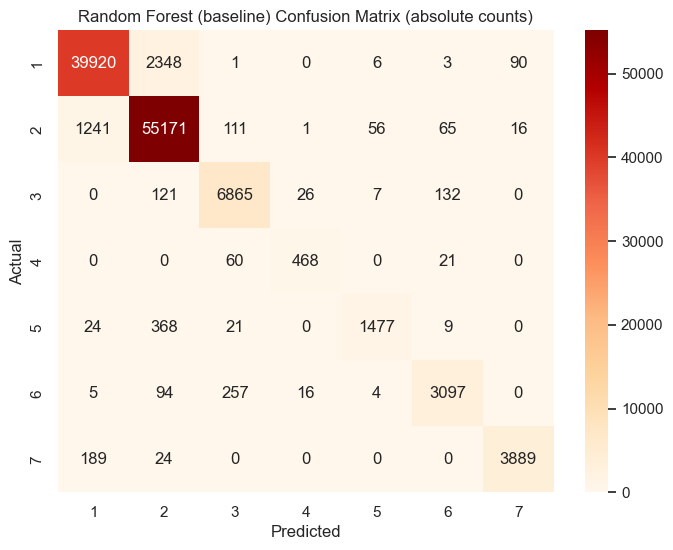

In [6]:
# Random Forest baseline
print("\nTraining Random Forest baseline...")
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=RANDOM_STATE)


import time  
t0 = time.time()  # Use the time module directly
rf.fit(X_train_scaled, y_train)
t_rf = time.time() - t0  # Calculate elapsed time

y_pred_rf = rf.predict(X_test_scaled)
print(f"Random Forest trained in {t_rf:.1f}s")
show_results(y_test, y_pred_rf, "Random Forest (baseline)")


Training XGBoost baseline...
XGBoost trained in 40.7s
--- XGBoost (baseline) ---
Accuracy: 0.8696
Classification report:
              precision    recall  f1-score   support

           0     0.8627    0.8407    0.8515     42368
           1     0.8671    0.8963    0.8815     56661
           2     0.8899    0.9095    0.8996      7151
           3     0.8787    0.8579    0.8682       549
           4     0.8891    0.6077    0.7219      1899
           5     0.8493    0.7970    0.8223      3473
           6     0.9508    0.9139    0.9320      4102

    accuracy                         0.8696    116203
   macro avg     0.8839    0.8319    0.8539    116203
weighted avg     0.8697    0.8696    0.8690    116203



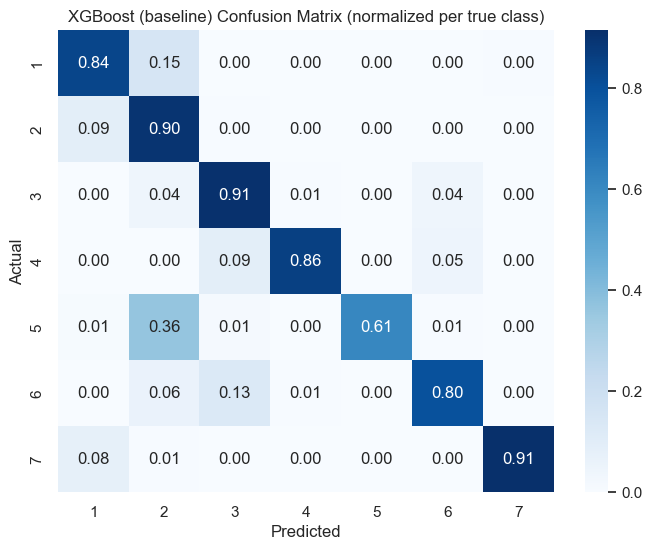

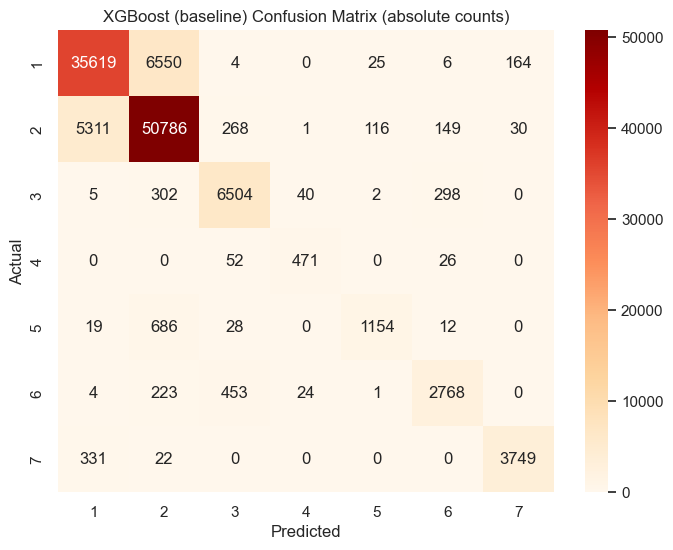

In [7]:
#XGBoost baseline
print("\nTraining XGBoost baseline...")
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=7,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbosity=0
)
t0 = time.time()  
xgb.fit(X_train_scaled, y_train)
t_xgb = time.time() - t0 
y_pred_xgb = xgb.predict(X_test_scaled)
print(f"XGBoost trained in {t_xgb:.1f}s") 
show_results(y_test, y_pred_xgb, "XGBoost (baseline)")

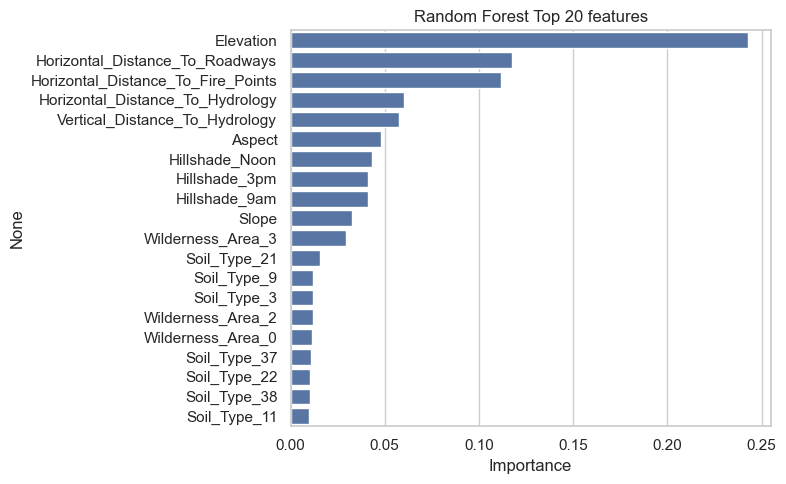

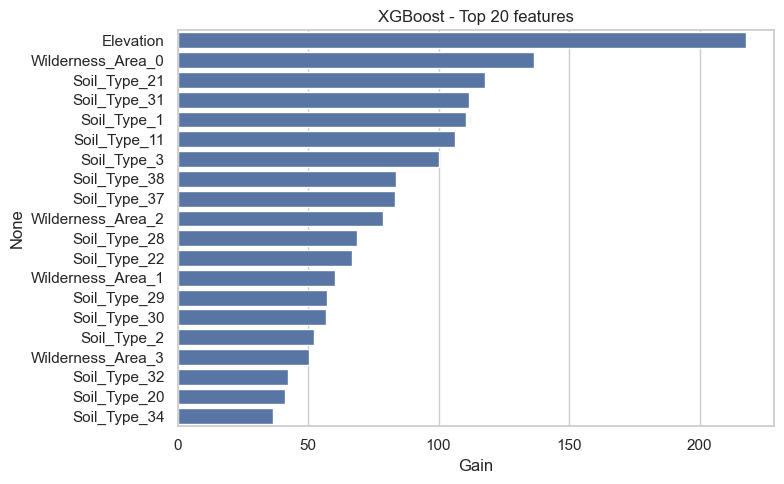

In [8]:
#Random Forest feature importance

def plot_feature_importances_from_rf(model, feature_names, top_n=20, title="RF Feature Importance"):
    if not hasattr(model, "feature_importances_"):
        print("Model has no feature_importances_ attribute")
        return

    imp = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)[:top_n]
    plt.figure(figsize=(8, max(4, 0.25*top_n)))
    sns.barplot(x=imp.values, y=imp.index)
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

#XGBoost feature importance (gain)
def plot_feature_importances_from_xgb(model, feature_names, top_n=20, title="XGB Feature Importance (gain)"):
    try:
        booster = model.get_booster()
        score = booster.get_score(importance_type='gain')

        #Map 'f0', 'f1', .. to feature names
        fseries = pd.Series({feature_names[int(k[1:])]: v for k, v in score.items()})
        fseries = fseries.sort_values(ascending=False)[:top_n]

        plt.figure(figsize=(8, max(4, 0.25*top_n)))
        sns.barplot(x=fseries.values, y=fseries.index)
        plt.title(title)
        plt.xlabel("Gain")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Could not extract XGBoost importances", e)
        
# Example usage:
feature_names = X.columns.tolist()
feature_names = X.columns.tolist()
plot_feature_importances_from_rf(rf, feature_names, top_n=20, title="Random Forest Top 20 features")
plot_feature_importances_from_xgb(xgb, feature_names, top_n=20, title="XGBoost - Top 20 features")

In [9]:
#5) Quick Comparison Summary

print("\nBaseline comparison:")
print(f"Random Forest accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"XGBoost accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")


Baseline comparison:
Random Forest accuracy: 0.9543
XGBoost accuracy: 0.8696
